# Adaptive RAG

이 튜토리얼은 Adaptive RAG(Adaptive Retrieval-Augmented Generation)의 구현을 다룹니다. 

Adaptive RAG는 쿼리 분석과 능동적/자기 수정 RAG를 결합하여 다양한 데이터 소스에서 정보를 검색하고 생성하는 전략입니다. 

이 튜토리얼에서는 LangGraph를 사용하여 웹 검색과 자기 수정 RAG 간의 라우팅을 구현합니다.

**주로 다루는 내용**

- **Create Index**: 인덱스 생성 및 문서 로드
- **LLMs**: LLM을 사용한 쿼리 라우팅 및 문서 평가
- **Web Search Tool**: 웹 검색 도구 설정
- **Construct the Graph**: 그래프 상태 및 흐름 정의
- **Compile Graph**: 그래프 컴파일 및 워크플로우 구축
- **Use Graph**: 그래프 실행 및 결과 확인

----

**Adaptive RAG**는 **RAG**의 전략으로, (1) [쿼리 분석](https://blog.langchain.dev/query-construction/)과 (2) [Self-Reflective RAG](https://blog.langchain.dev/agentic-rag-with-langgraph/)을 결합합니다.

[논문: Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity](https://arxiv.org/abs/2403.14403) 에서는 쿼리 분석을 통해 다음과 같은 라우팅을 수행합니다.

- `No Retrieval`
- `Single-shot RAG`
- `Iterative RAG`

LangGraph를 사용하여 이를 구현합니다.

이 구현에서는 다음과 같은 라우팅을 수행합니다.

- **웹 검색**: 최신 이벤트와 관련된 질문에 사용
- **자기 수정 RAG**: 인덱스와 관련된 질문에 사용

![adaptive-rag.png](./assets/langgraph-adaptive-rag.png)

## 환경 설정

In [1]:
# !pip install -U langchain-teddynote

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Structures")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Structures


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

**참고**

- 이전 튜토리얼에서 다룬 내용이므로, 자세한 설명은 생략합니다.

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever 생성
pdf_retriever = pdf.retriever

# chain 생성
pdf_chain = pdf.chain

## 쿼리 라우팅과 문서 평가

**LLMs** 단계에서는 **쿼리 라우팅**과 **문서 평가**를 수행합니다. 이 과정은 **Adaptive RAG**의 중요한 부분으로, 효율적인 정보 검색과 생성에 기여합니다.

- **쿼리 라우팅**: 사용자의 쿼리를 분석하여 적절한 정보 소스로 라우팅합니다. 이를 통해 쿼리의 목적에 맞는 최적의 검색 경로를 설정할 수 있습니다.
- **문서 평가**: 검색된 문서의 품질과 관련성을 평가하여 최종 결과의 정확성을 높입니다. 이 과정은 **LLMs**의 성능을 극대화하는 데 필수적입니다.

이 단계는 **Adaptive RAG**의 핵심 기능을 지원하며, 정확하고 신뢰할 수 있는 정보 제공을 목표로 합니다.

In [4]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# 최신 LLM 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)


# 사용자 쿼리를 가장 관련성 높은 데이터 소스로 라우팅하는 데이터 모델
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    # 데이터 소스 선택을 위한 리터럴 타입 필드
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM 초기화 및 함수 호출을 통한 구조화된 출력 생성
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# 시스템 메시지와 사용자 질문을 포함한 프롬프트 템플릿 생성
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to DEC 2023 AI Brief Report(SPRI) with Samsung Gause, Anthropic, etc.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# Routing 을 위한 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 라우터를 결합하여 질문 라우터 생성
question_router = route_prompt | structured_llm_router

다음은 쿼리 라우팅 결과를 테스트 해본 뒤 결과를 확인합니다.

In [5]:
# 문서 검색이 필요한 질문
print(
    question_router.invoke(
        {"question": "AI Brief 에서 삼성전자가 만든 생성형 AI 의 이름은?"}
    )
)

datasource='vectorstore'


In [6]:
# 웹 검색이 필요한 질문
print(question_router.invoke({"question": "판교에서 가장 맛있는 딤섬집 찾아줘"}))

datasource='web_search'


### 검색 평가기(Retrieval Grader)

In [8]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


# 문서 평가를 위한 데이터 모델 정의
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화 및 함수 호출을 통한 구조화된 출력 생성
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 메시지와 사용자 질문을 포함한 프롬프트 템플릿 생성
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 문서 검색결과 평가기 생성
retrieval_grader = grade_prompt | structured_llm_grader

생성한 `retrieval_grader` 를 사용하여 문서 검색결과를 평가합니다.

In [9]:
# 사용자 질문 설정
question = "삼성전자가 만든 생성형 AI 의 이름은?"

# 질문에 대한 관련 문서 검색
docs = pdf_retriever.invoke(question)

In [10]:
# 검색된 문서의 내용 가져오기
retrieved_doc = docs[1].page_content

# 평가 결과 출력
print(retrieval_grader.invoke({"question": question, "document": retrieved_doc}))

binary_score='yes'


In [11]:
# 필터링 하는 코드 예시
filtered_docs = []
for doc in docs:
    result = retrieval_grader.invoke(
        {
            "question": question,
            "document": doc.page_content,
        }
    )
    if result.binary_score == "yes":
        filtered_docs.append(doc)

### 답변 생성을 위한 RAG 체인 생성

In [12]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LangChain Hub에서 프롬프트 가져오기(RAG 프롬프트는 자유롭게 수정 가능)
prompt = hub.pull("teddynote/rag-prompt")

# LLM 초기화
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()

이제 생성한 `rag_chain` 에 질문을 전달하여 답변을 생성합니다.

In [13]:
# RAG 체인에 질문을 전달하여 답변 생성
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

삼성전자가 만든 생성형 AI의 이름은 '삼성 가우스'입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)


### 답변의 Hallucination 체커 추가

In [14]:
# 할루시네이션 체크를 위한 데이터 모델 정의
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# 함수 호출을 통한 LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# 프롬프트 설정
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 프롬프트 템플릿 생성
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# 환각 평가기 생성
hallucination_grader = hallucination_prompt | structured_llm_grader

생성한 `hallucination_grader` 를 사용하여 생성된 답변의 환각 여부를 평가합니다.

In [15]:
# 평가기를 사용하여 생성된 답변의 환각 여부 평가
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='no')

In [16]:
class GradeAnswer(BaseModel):
    """Binary scoring to evaluate the appropriateness of answers to questions"""

    binary_score: str = Field(
        description="Indicate 'yes' or 'no' whether the answer solves the question"
    )


# 함수 호출을 통한 LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# 프롬프트 설정
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 평가기를 결합하여 답변 평가기 생성
answer_grader = answer_prompt | structured_llm_grader

In [17]:
# 평가기를 사용하여 생성된 답변이 질문을 해결하는지 여부 평가
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

### 쿼리 재작성(Query Rewriter)

In [18]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Query Rewriter 프롬프트 정의(자유롭게 수정이 가능합니다)
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# Query Rewriter 프롬프트 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Query Rewriter 생성
question_rewriter = re_write_prompt | llm | StrOutputParser()

생성한 `question_rewriter` 에 질문을 전달하여 개선된 질문을 생성합니다.

In [19]:
# 질문 재작성기에 질문을 전달하여 개선된 질문 생성
question_rewriter.invoke({"question": question})

'삼성전자가 개발한 생성형 AI의 명칭은 무엇인가요?'

### 웹 검색 도구

**웹 검색 도구**는 **Adaptive RAG**의 중요한 구성 요소로, 최신 정보를 검색하는 데 사용됩니다. 이 도구는 사용자가 최신 이벤트와 관련된 질문에 대해 신속하고 정확한 답변을 얻을 수 있도록 지원합니다.

- **설정**: 웹 검색 도구를 설정하여 최신 정보를 검색할 수 있도록 준비합니다.
- **검색 수행**: 사용자의 쿼리를 기반으로 웹에서 관련 정보를 검색합니다.
- **결과 분석**: 검색된 결과를 분석하여 사용자의 질문에 가장 적합한 정보를 제공합니다.

In [20]:
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색 도구 생성
web_search_tool = TavilySearch(max_results=3)

웹 검색 도구를 실행하여 결과를 확인합니다.

In [21]:
# 웹 검색 도구 호출
result = web_search_tool.search("테디노트 위키독스 랭체인 튜토리얼 URL 을 알려주세요")
print(result)

[{'url': 'https://www.youtube.com/watch?v=mVu6Wj8Z7C0', 'title': '랭체인 한국어 튜토리얼 업데이트 소식 처음 사용자를 위한 친절한 ...', 'content': '#랭체인 한국어 튜토리얼🇰🇷 업데이트 소식🔥 처음 사용자를 위한 친절한 환경설치(Windows, Mac)\n\n테디노트 TeddyNote\n317 likes\n16451 views\n19 Jun 2024\n📝 환경설정(Windows)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Windows)/\n\n📝 환경설정(Mac)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Mac)/\n\n📍[패스트캠퍼스] "테디노트의 RAG 비법노트" 강의\n링크: https://bit.ly/4e1h8zO\n\n🤖 디스코드 채널\nhttps://discord.gg/q3RvQZ5CfK\n\n📘 랭체인 튜토리얼 무료 전자책(wikidocs)\nhttps://wikidocs.net/book/14314\n\n✅ 랭체인 한국어 튜토리얼 코드저장소(GitHub)\nhttps://github.com/teddylee777/langchain-kr\n\n✅ 줄거리\n00:00 랭체인 한국어 튜토리얼 공지사항\n01:59 langchain-teddynote 패키지\n08:25 감사인사\n09:15 Windows 환경설치\n21:48 Mac 환경설치\n\n#rag #langchain\n---\n📍 "테디노트의 RAG 비법노트" 랭체인 강의: https://fastcampus.co.kr/data_online_teddy\n📘 랭체인 한국어 튜토리얼(무료 전자책): https://wikidocs.net/

In [22]:
# 웹 검색 결과의 첫 번째 결과 확인
result[0]

{'url': 'https://www.youtube.com/watch?v=mVu6Wj8Z7C0',
 'title': '랭체인 한국어 튜토리얼 업데이트 소식 처음 사용자를 위한 친절한 ...',
 'content': '#랭체인 한국어 튜토리얼🇰🇷 업데이트 소식🔥 처음 사용자를 위한 친절한 환경설치(Windows, Mac)\n\n테디노트 TeddyNote\n317 likes\n16451 views\n19 Jun 2024\n📝 환경설정(Windows)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Windows)/\n\n📝 환경설정(Mac)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Mac)/\n\n📍[패스트캠퍼스] "테디노트의 RAG 비법노트" 강의\n링크: https://bit.ly/4e1h8zO\n\n🤖 디스코드 채널\nhttps://discord.gg/q3RvQZ5CfK\n\n📘 랭체인 튜토리얼 무료 전자책(wikidocs)\nhttps://wikidocs.net/book/14314\n\n✅ 랭체인 한국어 튜토리얼 코드저장소(GitHub)\nhttps://github.com/teddylee777/langchain-kr\n\n✅ 줄거리\n00:00 랭체인 한국어 튜토리얼 공지사항\n01:59 langchain-teddynote 패키지\n08:25 감사인사\n09:15 Windows 환경설치\n21:48 Mac 환경설치\n\n#rag #langchain\n---\n📍 "테디노트의 RAG 비법노트" 랭체인 강의: https://fastcampus.co.kr/data_online_teddy\n📘 랭체인 한국어 튜토리얼(무료 전자책): https://wikidocs.net

## 그래프 구성

### 그래프 상태 정의

In [23]:
from typing import List
from typing_extensions import TypedDict, Annotated


# 그래프의 상태 정의
class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 질문
        generation: LLM 생성된 답변
        documents: 도큐먼트 리스트
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

## 그래프 흐름 정의

**그래프 흐름**을 정의하여 **Adaptive RAG**의 작동 방식을 명확히 합니다. 이 단계에서는 그래프의 상태와 전환을 설정하여 쿼리 처리의 효율성을 높입니다.

- **상태 정의**: 그래프의 각 상태를 명확히 정의하여 쿼리의 진행 상황을 추적합니다.
- **전환 설정**: 상태 간의 전환을 설정하여 쿼리가 적절한 경로를 따라 진행되도록 합니다.
- **흐름 최적화**: 그래프의 흐름을 최적화하여 정보 검색과 생성의 정확성을 향상시킵니다.

### 노드 정의

In [24]:
from langchain_core.documents import Document


# 문서 검색 노드
def retrieve(state):
    print("==== [RETRIEVE] ====")
    question = state["question"]

    # 문서 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# 답변 생성 노드
def generate(state):
    print("==== [GENERATE] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # RAG 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 문서 관련성 평가 노드
def grade_documents(state):
    print("==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # 각 문서에 대한 관련성 점수 계산
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            # 관련성이 있는 문서 추가
            filtered_docs.append(d)
        else:
            # 관련성이 없는 문서는 건너뛰기
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}


# 질문 재작성 노드
def transform_query(state):
    print("==== [TRANSFORM QUERY] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


# 웹 검색 노드
def web_search(state):
    print("==== [WEB SEARCH] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]

    # 웹 검색 수행
    web_results = web_search_tool.invoke({"query": question})
    web_results_docs = [
        Document(
            page_content=web_result["content"],
            metadata={"source": web_result["url"]},
        )
        for web_result in web_results
    ]

    return {"documents": web_results_docs}

## 추가 노드 정의

In [25]:
# 질문 라우팅 노드
def route_question(state):
    print("==== [ROUTE QUESTION] ====")
    # 질문 가져오기
    question = state["question"]
    # 질문 라우팅
    source = question_router.invoke({"question": question})
    # 질문 라우팅 결과에 따른 노드 라우팅
    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        return "vectorstore"


# 문서 관련성 평가 노드
def decide_to_generate(state):
    print("==== [DECISION TO GENERATE] ====")
    # 문서 검색 결과 가져오기
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 관련성 없는 경우 질문 재작성
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # 관련성 있는 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        return "generate"


def hallucination_check(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # 환각 평가
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Hallucination 여부 확인
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")

        # 답변의 관련성(Relevance) 평가
        print("==== [GRADE GENERATED ANSWER vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score

        # 관련성 평가 결과에 따른 처리
        if grade == "yes":
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"

### 그래프 컴파일

**그래프 컴파일** 단계에서는 **Adaptive RAG**의 워크플로우를 구축하고 실행 가능한 상태로 만듭니다. 이 과정은 그래프의 각 노드와 엣지를 연결하여 쿼리 처리의 전체 흐름을 정의합니다.

- **노드 정의**: 각 노드를 정의하여 그래프의 상태와 전환을 명확히 합니다.
- **엣지 설정**: 노드 간의 엣지를 설정하여 쿼리가 적절한 경로를 따라 진행되도록 합니다.
- **워크플로우 구축**: 그래프의 전체 흐름을 구축하여 정보 검색과 생성의 효율성을 극대화합니다.

In [26]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("web_search", web_search)  # 웹 검색
workflow.add_node("retrieve", retrieve)  # 문서 검색
workflow.add_node("grade_documents", grade_documents)  # 문서 평가
workflow.add_node("generate", generate)  # 답변 생성
workflow.add_node("transform_query", transform_query)  # 쿼리 변환

# 그래프 빌드
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",  # 웹 검색으로 라우팅
        "vectorstore": "retrieve",  # 벡터스토어로 라우팅
    },
)
workflow.add_edge("web_search", "generate")  # 웹 검색 후 답변 생성
workflow.add_edge("retrieve", "grade_documents")  # 문서 검색 후 평가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",  # 쿼리 변환 필요
        "generate": "generate",  # 답변 생성 가능
    },
)
workflow.add_edge("transform_query", "retrieve")  # 쿼리 변환 후 문서 검색
workflow.add_conditional_edges(
    "generate",
    hallucination_check,
    {
        "hallucination": "generate",  # Hallucination 발생 시 재생성
        "relevant": END,  # 답변의 관련성 여부 통과
        "not relevant": "transform_query",  # 답변의 관련성 여부 통과 실패 시 쿼리 변환
    },
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

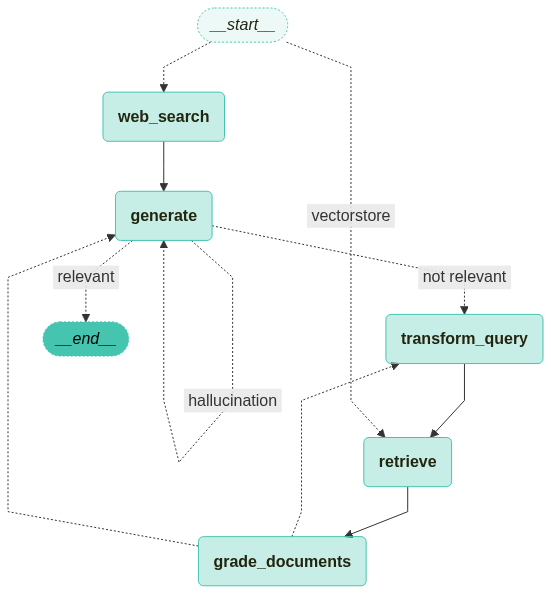

In [27]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 사용

**그래프 사용** 단계에서는 **Adaptive RAG**의 실행을 통해 쿼리 처리 결과를 확인합니다. 이 과정은 그래프의 각 노드와 엣지를 따라 쿼리를 처리하여 최종 결과를 생성합니다.

- **그래프 실행**: 정의된 그래프를 실행하여 쿼리의 흐름을 따라갑니다.
- **결과 확인**: 그래프 실행 후 생성된 결과를 검토하여 쿼리가 적절히 처리되었는지 확인합니다.
- **결과 분석**: 생성된 결과를 분석하여 쿼리의 목적에 부합하는지 평가합니다.

In [28]:
from langchain_teddynote.messages import stream_graph, random_uuid
from langchain_core.runnables import RunnableConfig

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 그래프 실행
stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])

==== [ROUTE QUESTION] ====
==== [ROUTE QUESTION TO VECTORSTORE] ====
==== [RETRIEVE] ====
==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
==== [DECISION TO GENERATE] ====
==== [DECISION: GENERATE] ====
==== [GENERATE] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)==== [CHECK HALLUCINATIONS] ====
{"binary_score":"yes"}==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====
==== [GRADE GENERATED ANSWER vs QUESTION] ====
{"binary_score":"yes"}==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====


In [29]:
# 질문 입력
inputs = {
    "question": "2024년 노벨 문학상 수상자는 누구인가요?",
}

# 그래프 실행
stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])

==== [ROUTE QUESTION] ====
==== [ROUTE QUESTION TO WEB SEARCH] ====
==== [WEB SEARCH] ====
==== [GENERATE] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨 문학상 수상자는 한국의 작가 한강입니다.

**Source**
- https://www.youtube.com/watch?v=FsMuWl5LYNA
- https://www.chosun.com/national/national_general/2024/10/10/NYUFG2FRHRFONLBT6BP6DAEUFQ/==== [CHECK HALLUCINATIONS] ====
{"binary_score":"yes"}==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====
==== [GRADE GENERATED ANSWER vs QUESTION] ====
{"binary_score":"yes"}==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====
